In [2]:
#try xgboost
import pandas as pd
import numpy as np
import xgboost as xgb

In [4]:
df = pd.read_csv('/Users/frankieshen/Desktop/ooschool/專案/stock_0050_final.csv', parse_dates = True, index_col = 0)

In [5]:
print(df.columns)
print(df.shape)
print(type(df))

Index(['Unnamed: 0', 'Capacity', 'Volume', 'Open', 'High', 'Low', 'Close',
       'Change', 'Transcation', 'Tomorrow', 'Target', 'SMA_20', 'RSI', 'slowk',
       'slowd', 'MACD', 'MACD_signal', 'MACD_hist', 'upper_band',
       'middle_band', 'lower_band'],
      dtype='object')
(3483, 21)
<class 'pandas.core.frame.DataFrame'>


In [6]:
df.head()

,Unnamed: 0,Capacity,Volume,Open,High,Low,Close,Change,Transcation,Tomorrow,...,SMA_20,RSI,slowk,slowd,MACD,MACD_signal,MACD_hist,upper_band,middle_band,lower_band
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-26,33,9391284,483837797,51.65,51.75,51.20,51.55,-0.10,1366,52.80,...,52.4075,38.424149,46.288720,50.743915,-1.500417,-1.927544,0.427127,54.411814,52.4075,50.403186
2010-03-01,34,13647130,715419506,51.50,52.95,51.50,52.80,1.25,2066,52.65,...,52.3275,47.850461,58.861819,52.243188,-1.336577,-1.809351,0.472774,54.124296,52.3275,50.530704
2010-03-02,35,9997438,528112268,52.75,53.10,52.55,52.65,-0.15,1225,52.65,...,52.2500,46.922188,71.092962,58.747834,-1.204946,-1.688470,0.483524,53.838710,52.2500,50.661290
2010-03-03,36,8764746,462426932,52.70,53.10,52.50,52.65,0.00,1041,52.20,...,52.2350,46.922188,84.210526,71.388436,-1.088085,-1.568393,0.480308,53.802514,52.2350,50.667486
2010-03-04,37,8149453,426373974,52.75,52.90,51.80,52.20,-0.45,1295,52.95,...,52.2000,43.955363,77.192982,77.498824,-1.020025,-1.458719,0.438694,53.737530,52.2000,50.662470


In [7]:
df_reorder = df[['Volume','Open', 'High', 'Low', 
              'SMA_20', 'RSI', 'slowk', 'slowd', 'MACD', 'MACD_signal', 'MACD_hist', 'upper_band', 'middle_band', 'lower_band', 'Close']]

In [8]:
print(df_reorder.columns)
print(df_reorder.shape)
print(type(df_reorder))

Index(['Volume', 'Open', 'High', 'Low', 'SMA_20', 'RSI', 'slowk', 'slowd',
       'MACD', 'MACD_signal', 'MACD_hist', 'upper_band', 'middle_band',
       'lower_band', 'Close'],
      dtype='object')
(3483, 15)
<class 'pandas.core.frame.DataFrame'>


In [9]:

def windowing(train, val, WINDOW, PREDICTION_SCOPE):
    assert type(train) == np.ndarray, "train must be passed as an array"
    assert type(val) == np.ndarray, "validation must be passed as an array"
    assert type(WINDOW) == int, "Window must be an integer"
    assert type(PREDICTION_SCOPE) == int, "Prediction score must be an integer"

    x_train = []
    y_train = []
    x_test = []
    y_test = []

    for i in range(len(train) - (WINDOW + PREDICTION_SCOPE)):
        x, y = np.array(train[i:i + WINDOW, :-1]), np.array(train[i + WINDOW + PREDICTION_SCOPE, -1])
        x_train.append(x)
        y_train.append(y)
    for i in range(len(val) - (WINDOW + PREDICTION_SCOPE)):
        x, y = np.array(val[i:i + WINDOW, :-1]), np.array(val[i + WINDOW + PREDICTION_SCOPE, -1])
        x_test.append(x)
        y_test.append(y)


    return x_train, y_train, x_test, y_test

In [10]:
def train_test_split(data, percentage):
    assert type(data) == pd.core.frame.DataFrame, "data must be a dataframe"
    assert type(percentage) == float, "percentage must be a float"

    train = data.iloc[:int(len(data) * percentage)]
    test = data.iloc[int(len(data) * percentage):]
    
    return train, test

In [11]:
def train_validation_split(train, percentage):
    assert type(train) == pd.core.frame.DataFrame, "train musst be a dataframe"
    assert type(percentage) == float, "percentage musst be a float"
    
    train_set = np.array(train.iloc[:int(len(train) * percentage)])
    validation_set = np.array(train.iloc[int(len(train) * percentage):])
    
    return train_set, validation_set

In [12]:
percentage = 0.8
WINDOW = 5
PREDICTION_SCOPE = 0

In [13]:
train, test = train_test_split(df_reorder, percentage)
train_set, validation_set = train_validation_split(train, percentage)
print(f"train_set shape: {train_set.shape}")
print(f"validation_set shape: {validation_set.shape}")
print(f"test shape: {test.shape}")
print(f"train shape: {train.shape}")

train_set shape: (2228, 15)
validation_set shape: (558, 15)
test shape: (697, 15)
train shape: (2786, 15)


In [14]:
X_train, y_train, X_val, y_val = windowing(train_set, validation_set, WINDOW, PREDICTION_SCOPE)
#Convert the returned list into arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (2223, 5, 14)
y_train shape: (2223,)
X_val shape: (553, 5, 14)
y_val shape: (553,)


In [15]:
#xgboost only allows two dimensional input
#reshape x_train and x_val into two dimension by joining the rows of the windowed days into one big input
X_train_2dim = X_train.reshape(X_train.shape[0], -1)
X_val_2dim = X_val.reshape(X_val.shape[0], -1)
print(f"X_train_new shape: {X_train_2dim.shape}")
print(f"X_val_new shape: {X_val_2dim.shape}")

X_train_new shape: (2223, 70)
X_val_new shape: (553, 70)


In [16]:
xgb_model = xgb.XGBRegressor(gamma=1, n_estimators=200)
xgb_model.fit(X_train_2dim, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
from sklearn.metrics import mean_absolute_error

In [18]:
pred_val = xgb_model.predict(X_val_2dim)
mae_val = mean_absolute_error(y_val, pred_val)
mae_val

16.271520689814256

In [19]:
#test the model
test_array = np.array(test)

In [20]:
test_array

array([[8.20657527e+08, 1.35600000e+02, 1.36050000e+02, ...,
        1.36685000e+02, 1.33561044e+02, 1.34850000e+02],
       [8.87399669e+08, 1.35000000e+02, 1.37150000e+02, ...,
        1.36817500e+02, 1.33872797e+02, 1.37050000e+02],
       [8.61039047e+08, 1.37050000e+02, 1.37250000e+02, ...,
        1.36927500e+02, 1.34179505e+02, 1.36700000e+02],
       ...,
       [1.28963079e+09, 1.57300000e+02, 1.59100000e+02, ...,
        1.57685000e+02, 1.50253237e+02, 1.58800000e+02],
       [7.61950562e+08, 1.58600000e+02, 1.59350000e+02, ...,
        1.57702500e+02, 1.50267147e+02, 1.58250000e+02],
       [1.04227977e+09, 1.57350000e+02, 1.57350000e+02, ...,
        1.57640000e+02, 1.50174573e+02, 1.56150000e+02]])

In [21]:
# test the model

X_test = []
y_test = []

for i in range(len(test_array) - (WINDOW + PREDICTION_SCOPE)):
    x, y = np.array(test_array[i:i + WINDOW, :-1]), np.array(test_array[i + WINDOW + PREDICTION_SCOPE, -1])
    X_test.append(x)
    y_test.append(y)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [22]:
print(test.shape)
print(X_test.shape)
print(y_test.shape)

(697, 15)
(692, 5, 14)
(692,)


In [23]:
#reshape X_test into 2 dimension array
X_test_2dim = X_test.reshape(X_test.shape[0], -1)
print(X_test_2dim)
print(X_test_2dim.shape)

[[8.20657527e+08 1.35600000e+02 1.36050000e+02 ... 1.39358453e+02
  1.37167500e+02 1.34976547e+02]
 [8.87399669e+08 1.35000000e+02 1.37150000e+02 ... 1.39391198e+02
  1.37192500e+02 1.34993802e+02]
 [8.61039047e+08 1.37050000e+02 1.37250000e+02 ... 1.39575539e+02
  1.37255000e+02 1.34934461e+02]
 ...
 [1.50595993e+09 1.50400000e+02 1.51750000e+02 ... 1.65010889e+02
  1.57590000e+02 1.50169111e+02]
 [8.68908321e+08 1.52150000e+02 1.52450000e+02 ... 1.65116763e+02
  1.57685000e+02 1.50253237e+02]
 [1.25853996e+09 1.54000000e+02 1.56500000e+02 ... 1.65137853e+02
  1.57702500e+02 1.50267147e+02]]
(692, 70)


In [24]:
xgb_model.fit(X_test_2dim, y_test)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [25]:
pred_test = xgb_model.predict(X_test_2dim)
mae_test = mean_absolute_error(y_test, pred_test)
mae_test

0.34766466879431246

In [26]:
X_test_2dim

array([[8.20657527e+08, 1.35600000e+02, 1.36050000e+02, ...,
        1.39358453e+02, 1.37167500e+02, 1.34976547e+02],
       [8.87399669e+08, 1.35000000e+02, 1.37150000e+02, ...,
        1.39391198e+02, 1.37192500e+02, 1.34993802e+02],
       [8.61039047e+08, 1.37050000e+02, 1.37250000e+02, ...,
        1.39575539e+02, 1.37255000e+02, 1.34934461e+02],
       ...,
       [1.50595993e+09, 1.50400000e+02, 1.51750000e+02, ...,
        1.65010889e+02, 1.57590000e+02, 1.50169111e+02],
       [8.68908321e+08, 1.52150000e+02, 1.52450000e+02, ...,
        1.65116763e+02, 1.57685000e+02, 1.50253237e+02],
       [1.25853996e+09, 1.54000000e+02, 1.56500000e+02, ...,
        1.65137853e+02, 1.57702500e+02, 1.50267147e+02]])

In [27]:
#投資回測分析
test_new = test.iloc[5:]
test_new["prediction"] = pred_test

/var/folders/xf/rrndggj14ddg8j43w4kdc53m0000gn/T/ipykernel_15362/3562115945.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_new["prediction"] = pred_test


In [28]:
test_new["pred_tomorrow"] = test_new["prediction"].shift(-1)
test_new["target"] = (test_new["pred_tomorrow"] > test_new["prediction"]).astype(int)
test_new["status"] = test_new["target"].shift(1).fillna(0)

/var/folders/xf/rrndggj14ddg8j43w4kdc53m0000gn/T/ipykernel_15362/2474377501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_new["pred_tomorrow"] = test_new["prediction"].shift(-1)
/var/folders/xf/rrndggj14ddg8j43w4kdc53m0000gn/T/ipykernel_15362/2474377501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_new["target"] = (test_new["pred_tomorrow"] > test_new["prediction"]).astype(int)
/var/folders/xf/rrndggj14ddg8j43w4kdc53m0000gn/T/ipykernel_15362/2474377501.py:3: SettingWithCopyWarning: 
A 

In [29]:
test_new.head(10)

,Volume,Open,High,Low,SMA_20,RSI,slowk,slowd,MACD,MACD_signal,MACD_hist,upper_band,middle_band,lower_band,Close,prediction,pred_tomorrow,target,status
Date,,,,,,,,,,,,,,,,,,,
2021-06-29,1259391696,137.90,138.70,137.30,137.1925,54.544531,61.111111,56.296296,0.424240,0.477480,-0.053239,139.391198,137.1925,134.993802,137.60,137.550995,138.198807,1,0.0
2021-06-30,1355932363,138.10,139.35,138.05,137.2550,59.089477,73.547155,63.034237,0.552769,0.492537,0.060232,139.575539,137.2550,134.934461,138.95,138.198807,138.708969,1,1.0
2021-07-01,649025587,139.00,139.20,138.05,137.2850,56.176981,79.663994,71.440753,0.595317,0.513093,0.082224,139.642986,137.2850,134.927014,138.30,138.708969,138.660843,0,1.0
2021-07-02,667110798,138.30,138.50,137.90,137.3200,56.176981,82.817869,78.676340,0.621868,0.534848,0.087020,139.716122,137.3200,134.923878,138.30,138.660843,138.688858,1,0.0
2021-07-05,1100359360,138.75,140.00,138.75,137.4525,60.673160,83.142768,81.874877,0.739287,0.575736,0.163551,140.037742,137.4525,134.867258,139.60,138.688858,140.094894,1,1.0
2021-07-06,915548456,139.85,140.05,139.45,137.5750,61.168224,88.557461,84.839366,0.834823,0.627554,0.207270,140.345289,137.5750,134.804711,139.75,140.094894,139.422394,0,1.0
2021-07-07,942786963,139.60,139.65,138.60,137.7000,57.285207,89.467649,87.055959,0.840331,0.670109,0.170222,140.490520,137.7000,134.909480,139.00,139.422394,139.020721,0,0.0
2021-07-08,567119389,139.15,139.50,138.20,137.8675,56.512522,84.684685,87.569932,0.823103,0.700708,0.122395,140.507817,137.8675,135.227183,138.85,139.020721,137.960388,0,0.0
2021-07-09,986007526,137.90,137.90,136.95,137.8750,51.072128,72.672673,82.275002,0.712477,0.703062,0.009415,140.513086,137.8750,135.236914,137.75,137.960388,138.193817,1,0.0


In [30]:
test_new.to_csv("stock_0050_testset.csv")

In [3]:
test_new = pd.read_csv('/Users/frankieshen/Desktop/ooschool/專案/stock_0050_testset.csv', parse_dates = True, index_col = 0)

In [4]:
test_new

,Volume,Open,High,Low,SMA_20,RSI,slowk,slowd,MACD,MACD_signal,MACD_hist,upper_band,middle_band,lower_band,Close,prediction,pred_tomorrow,target,status
Date,,,,,,,,,,,,,,,,,,,
2021-06-29,1259391696,137.90,138.70,137.30,137.1925,54.544531,61.111111,56.296296,0.424240,0.477480,-0.053239,139.391198,137.1925,134.993802,137.60,137.55100,138.19880,1,0.0
2021-06-30,1355932363,138.10,139.35,138.05,137.2550,59.089477,73.547155,63.034237,0.552769,0.492537,0.060232,139.575539,137.2550,134.934461,138.95,138.19880,138.70897,1,1.0
2021-07-01,649025587,139.00,139.20,138.05,137.2850,56.176981,79.663994,71.440753,0.595317,0.513093,0.082224,139.642986,137.2850,134.927014,138.30,138.70897,138.66084,0,1.0
2021-07-02,667110798,138.30,138.50,137.90,137.3200,56.176981,82.817869,78.676340,0.621868,0.534848,0.087020,139.716122,137.3200,134.923878,138.30,138.66084,138.68886,1,0.0
2021-07-05,1100359360,138.75,140.00,138.75,137.4525,60.673160,83.142768,81.874877,0.739287,0.575736,0.163551,140.037742,137.4525,134.867258,139.60,138.68886,140.09490,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-25,811673254,154.10,154.45,153.25,157.6725,46.689770,31.889290,22.623345,0.208731,1.440165,-1.231434,165.057449,157.6725,150.287551,153.50,153.79332,155.77031,1,0.0
2024-04-26,945852784,156.00,156.80,155.50,157.5900,51.286680,41.756919,32.731649,0.227043,1.197541,-0.970498,165.010889,157.5900,150.169111,156.00,155.77031,157.72922,1,1.0
2024-04-29,1289630787,157.30,159.10,157.30,157.6850,55.875854,47.734526,40.460245,0.462164,1.050465,-0.588301,165.116763,157.6850,150.253237,158.80,157.72922,157.97017,1,1.0


In [5]:
# 所以什麼時候要買股票就很好找了：status 從 0 變成 1 的時候，1 的那天的開盤買進（因為 status 已經位移一天了喔）
# 從 prediction 的角度解釋就是：當 A.I. 的預測從 0 變成 1 的時候，1 的隔天的開盤買進
test_new["buy_cost"] = test_new.Open[np.where((test_new.status == 1) * (test_new.status.shift(1) == 0))[0]]

# 同理，賣股票也很好找：status 從 1 變成 0 的時候，0 的那天的開盤賣出
test_new["sell_cost"] = test_new.Open[np.where((test_new.status == 0) * (test_new.status.shift(1) == 1))[0]]

# 把缺值補上 0
test_new = test_new.fillna(0)

/var/folders/xf/rrndggj14ddg8j43w4kdc53m0000gn/T/ipykernel_27339/2825028070.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_new["buy_cost"] = test_new.Open[np.where((test_new.status == 1) * (test_new.status.shift(1) == 0))[0]]
/var/folders/xf/rrndggj14ddg8j43w4kdc53m0000gn/T/ipykernel_27339/2825028070.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_new["sell_cost"] = test_new.Open[np.where((test_new.status == 0) * (test_new.status.shift(1) == 1))[0]]


In [6]:
# 來算算每次買賣的報酬率吧！
# 一買一賣是剛好對應的，所以把買的成本以及賣的價格這兩欄的數字取出，就能輕易的算出交易報酬率
buy_cost = np.array(test_new.buy_cost[test_new.buy_cost != 0])
sell_price = np.array(test_new.sell_cost[test_new.sell_cost != 0])

In [7]:
len(buy_cost) == len(sell_price)
#持股均有賣出

True

In [8]:
# 交易都會有交易成本，例如台股每次一買一賣約產生 0.6% 的交易成本。
# 買賣 SPY ETF 也會有交易成本，管理費用約 0.1%，券商手續費因人而異，但近年來此費用逐漸趨近於 0，這裡就假設 0.1% 手續費好了
# 因此這裡額外計算一個把每次交易報酬率扣除總交易成本約 0.2% 的淨報酬率
# ETF 0050 經理費是0.32%
trade_return = (sell_price - buy_cost) / buy_cost
fee = 0.0032
net_trade_return = trade_return - fee

In [9]:
#從這邊開始
#把報酬率都放進表格吧！
test_new['trade_ret'] = 0
test_new['net_trade_ret'] = 0
sell_dates = test_new.sell_cost[test_new.sell_cost != 0].index
test_new.loc[sell_dates, 'trade_ret'] = trade_return
test_new.loc[sell_dates, 'net_trade_ret'] = net_trade_return

/var/folders/xf/rrndggj14ddg8j43w4kdc53m0000gn/T/ipykernel_27339/1338664821.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.00144823  0.00612613  0.00539374  0.00181422  0.01729849 -0.0010921
  0.06540643  0.01528617  0.00426439 -0.02141328  0.00324207  0.01193584
  0.02397004  0.00367107 -0.00183486  0.00585437  0.00623167  0.01458789
  0.02098897 -0.0049054   0.03149891  0.00282087  0.01213419  0.03731343
  0.01575342  0.04246575 -0.03097643  0.00316678  0.01983705 -0.00277971
 -0.00395541  0.02760968  0.03903904 -0.01050344  0.01761619  0.00756144
 -0.00271528 -0.01441933  0.01105651  0.01010101  0.0105093   0.04148208
 -0.00233918 -0.01322957  0.00620091  0.00834725 -0.01377166  0.03837369
  0.01460177  0.02062308  0.02251082  0.02377864  0.01335559 -0.03003755
 -0.00388098 -0.00876424 -0.01951431  0.00222124  0.02725968 -0.01769042
 -0.00689655  0.00101523 -0.00354072  0.05453619  0.05941962  0.0035103

In [19]:
# 如果還想要畫出績效走勢圖，那就要把策略的報酬率也算出來，由於我們不論買賣都是以開盤價進行，所以策略的報酬率會使用開盤價計算
test_new['open_ret'] = test_new.Open / test_new.Open.shift(1) - 1
test_new['strategy_ret'] = test_new.status.shift(1) * test_new.open_ret
test_new['strategy_net_ret'] = test_new.strategy_ret
test_new.loc[sell_dates, 'strategy_net_ret'] = test_new.loc[sell_dates, 'strategy_net_ret'] - fee
test_new = test_new.fillna(0)

# 'open_ret': 計算當天開盤價相對前一天開盤價的變化率（收益率），用來衡量股票在當日開盤時相對於前一天開盤時的價格變動百分比

In [21]:
# 計算出績效走勢圖
test_new['buy_and_hold_equity'] = (test_new.open_ret + 1).cumprod()
test_new['strategy_equity'] = (test_new.strategy_ret + 1).cumprod()
test_new['strategy_net_equity'] = (test_new.strategy_net_ret + 1).cumprod()

# cumprod(): 計算累積乘積（cumulative product），在財務分析中常用於計算累積收益率
# 'buy_and_hold_equity':累積收益率，加一是為了將收益率轉換成增長因子，當open_ret > 1收益率增加；open_ret < 1收益率減少

In [30]:
# 計算出一些有用的策略績效數字吧！
trade_count = len(sell_dates)
trade_count_per_year = trade_count / (len(test_new) / 252)
win_rate = (net_trade_return > 0).sum() / trade_count
profit_factor = net_trade_return[net_trade_return > 0].sum() / abs(net_trade_return[net_trade_return < 0].sum())
mean_net_return = np.mean(net_trade_return)
acc_ret = test_new.strategy_net_equity[-1] - 1
strategy_ear = test_new.strategy_net_equity[-1] ** (252/len(test_new)) - 1
strategy_std = test_new.strategy_net_ret.std() * (252 ** 0.5)
strategy_sharpe = (strategy_ear - 0.01) / strategy_std

# 252是股市一年中通常有交易的天數
# 計算每年交易次數、勝率、盈虧比、平均淨收益率、累積收益率、年化收益率 (strategy_ear)、波動率 (strategy_std) 和夏普比率 (strategy_sharpe)
# 盈虧比 (profit_factor) 表示每虧損 1 單位的資金，能產生多少單位的盈利。>1:策略的總盈利大於總虧損，表示策略是盈利的。=1:策略的總盈利等於總虧損，表示策略盈虧相抵。<1:策略的總盈利小於總虧損，表示策略是虧損的。
# 年化收益率（strategy_ear）即若策略在相同條件下延續一整年，期望能獲得的收益率。使用年化收益率可以比較不同回測時間段和不同策略的績效，因為它將收益率標準化為每年的收益表現。
# 標準差轉換為年化波動率的公式是每日標準差乘以每年的交易日數的平方根。這是因為標準差在不同時間尺度下的變化是以平方根的形式進行的。
# 高夏普比率：表示策略每單位風險所獲得的回報較高，策略風險調整後的表現優異。
# 低夏普比率：表示策略的回報相對於風險不佳，可能回報不夠補償所承擔的風險。


/var/folders/xf/rrndggj14ddg8j43w4kdc53m0000gn/T/ipykernel_27339/4029093256.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  acc_ret = test_new.strategy_net_equity[-1] - 1
/var/folders/xf/rrndggj14ddg8j43w4kdc53m0000gn/T/ipykernel_27339/4029093256.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_ear = test_new.strategy_net_equity[-1] ** (252/len(test_new)) - 1


In [36]:
print(f'交易次數：{trade_count}\n年平均交易次數：{trade_count_per_year}\n勝率：{win_rate}\n盈虧比：{profit_factor}\n平均淨收益率：{mean_net_return}\n累積收益率：{acc_ret}\n年化收益率：{strategy_ear}\n波動率：{strategy_std}\n夏普比率：{strategy_sharpe}')



交易次數：131
年平均交易次數：47.70520231213873
勝率：0.648854961832061
盈虧比：3.2521511014998454
平均淨收益率：0.007268328759493918
累積收益率：1.5150103140472604
年化收益率：0.39914042163470875
波動率：0.12210875039015529
夏普比率：3.186834853287322


In [44]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Equity Value')

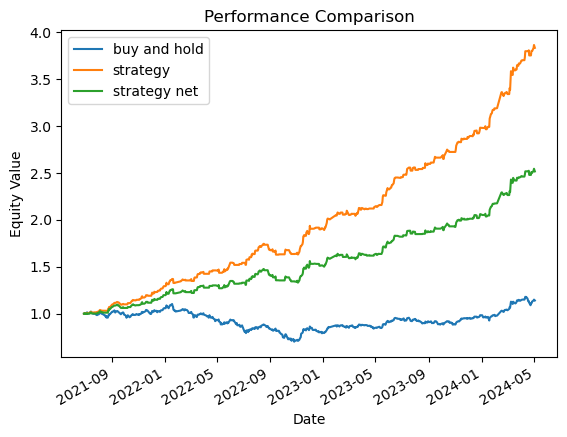

In [47]:
# 也畫出績效走勢看看吧！
test_new.buy_and_hold_equity.plot(label = 'buy and hold')
test_new.strategy_equity.plot(label = 'strategy')
test_new.strategy_net_equity.plot(label = 'strategy net')
plt.legend()
plt.title('Performance Comparison')
plt.ylabel('Equity Value')

In [48]:
test_new.to_csv("stock_0050_testset_240908.csv")